In [28]:
import pandas as pd
import contractions
import re
import csv
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [29]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    
    # Remove URLs
    text = re.sub(r'(http[s]?://\S+|www\.\S+)', '', text)

    # Remove special characters
    text = re.sub(r'[^\w\s]', '', text)
    
    # Split numbers and chars
    text = re.sub(r'(?<=\d)(?=[a-zA-Z])|(?<=[a-zA-Z])(?=\d)', ' ', text)
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [30]:
def expand(text):
    with open('abbreviations.csv', mode='r', encoding='utf-8') as file:
        reader = csv.reader(file)
        abbreviations = {rows[0]: rows[1] for rows in reader}

    words = text.split()
    for i in range(len(words)):
        word = words[i].lower()
        if word in abbreviations:
            if (word != 'pm') or (word == 'pm' and i > 0 and words[i-1].isalpha()):
                words[i] = abbreviations[word]
    return ' '.join(words)

In [31]:
def preprocessing(path):
    try:
        df = pd.read_csv(path)
        output_file = 'CLAN_data_preprocessed.csv'

        with open(output_file, 'w', newline='', encoding='utf-8') as f:
            f.write(','.join(df.columns) + '\n')

            for index, row in df.iterrows():
                # Process text
                text = contractions.fix(row['Social Media Post'])
                text = expand(text)
                text = clean_text(text)
                row['Social Media Post'] = text

                # Quote column 1 and 2
                row[df.columns[1]] = f'"{str(row[df.columns[1]]).replace("\"", "\"\"")}"'
                row[df.columns[2]] = f'"{str(row[df.columns[2]]).replace("\"", "\"\"")}"'

                f.write(','.join(str(row[col]) for col in df.columns) + '\n')

    except Exception as e:
        print(f"Error: {e}")

In [32]:
# preprocessing('CLAN_data.csv')

In [33]:
MODEL_NAME_T5 = "t5-small"
MAX_INPUT_LEN = 256
MAX_TARGET_LEN = 256
BATCH_SIZE = 8
EPOCHS = 10
LEARNING_RATE = 3e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
PROMPT = "Normalize Claim: "

In [34]:
df = pd.read_csv("CLAN_data_preprocessed.csv")
df = df.dropna(subset=["Social Media Post", "Normalized Claim"])
df["input_text"] = PROMPT + df["Social Media Post"]
df["target_text"] = df["Normalized Claim"]

df_train, df_temp = train_test_split(df, test_size=0.30, random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, random_state=42)

print(f"Train size: {len(df_train)} | Val size: {len(df_val)} | Test size: {len(df_test)}")

Train size: 1967 | Val size: 422 | Test size: 422


In [21]:
class T5Dataset(Dataset):
    def __init__(self, dataframe, tokenizer):
        self.tokenizer = tokenizer
        self.inputs = dataframe["input_text"].tolist()
        self.targets = dataframe["target_text"].tolist()
        self.pids = dataframe["PID"].tolist()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_enc = self.tokenizer(self.inputs[idx], truncation=True, padding="max_length", max_length=MAX_INPUT_LEN, return_tensors="pt")
        target_enc = self.tokenizer(self.targets[idx], truncation=True, padding="max_length", max_length=MAX_TARGET_LEN, return_tensors="pt")

        return {
            "input_ids": input_enc["input_ids"].squeeze(),
            "attention_mask": input_enc["attention_mask"].squeeze(),
            "labels": target_enc["input_ids"].squeeze(),
            "pid": self.pids[idx]
        }


In [ ]:
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME_T5)
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME_T5).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

train_dataset = T5Dataset(df_train, tokenizer)
val_dataset = T5Dataset(df_val, tokenizer)
test_dataset = T5Dataset(df_test, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [ ]:
train_loss_log, val_loss_log = [], []
best_val_loss = float("inf")

for epoch in range(EPOCHS):
    # training loop
    model.train()
    train_loss = 0
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    for batch in tqdm(train_loader):
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)
        labels = batch["labels"].to(DEVICE)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_loss_log.append(avg_train_loss)
    print(f"Average Loss: {avg_train_loss:.4f}")

    # validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_loss_log.append(avg_val_loss)
    print(f"Validation Loss: {avg_val_loss:.4f}")

    # Save model if validation improves
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "t5_finetuned.pt")

print("Training complete.")


Epoch 1/10


100%|██████████| 246/246 [02:41<00:00,  1.52it/s]


Average Loss: 0.6492
Validation Loss: 0.3121

Epoch 2/10


100%|██████████| 246/246 [02:41<00:00,  1.52it/s]


Average Loss: 0.3095
Validation Loss: 0.2863

Epoch 3/10


100%|██████████| 246/246 [02:46<00:00,  1.47it/s]


Average Loss: 0.2800
Validation Loss: 0.2759

Epoch 4/10


100%|██████████| 246/246 [02:47<00:00,  1.47it/s]


Average Loss: 0.2604
Validation Loss: 0.2705

Epoch 5/10


100%|██████████| 246/246 [02:46<00:00,  1.48it/s]


Average Loss: 0.2438
Validation Loss: 0.2672

Epoch 6/10


100%|██████████| 246/246 [02:46<00:00,  1.47it/s]


Average Loss: 0.2296
Validation Loss: 0.2647

Epoch 7/10


100%|██████████| 246/246 [02:47<00:00,  1.47it/s]


Average Loss: 0.2154
Validation Loss: 0.2650

Epoch 8/10


100%|██████████| 246/246 [02:46<00:00,  1.48it/s]


Average Loss: 0.2031
Validation Loss: 0.2636

Epoch 9/10


100%|██████████| 246/246 [02:46<00:00,  1.48it/s]


Average Loss: 0.1915
Validation Loss: 0.2644

Epoch 10/10


100%|██████████| 246/246 [03:16<00:00,  1.25it/s]


Average Loss: 0.1795
Validation Loss: 0.2671
Training complete.


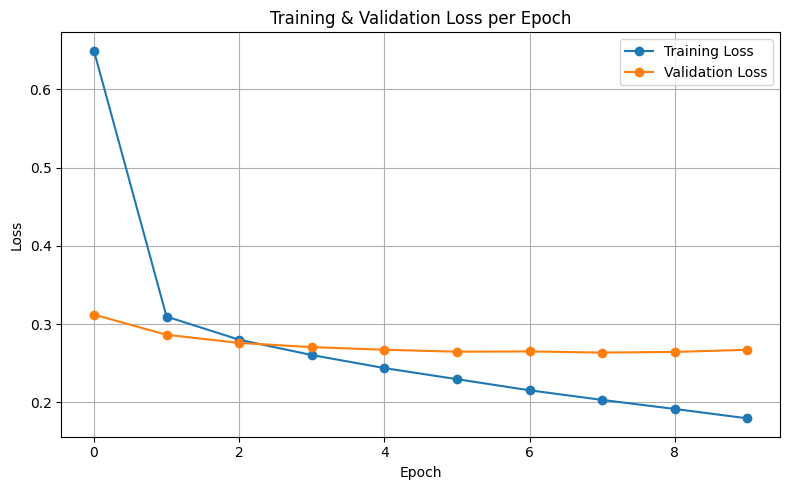

In [10]:
plt.figure(figsize=(8, 5))
plt.plot(train_loss_log, label="Training Loss", marker='o')
plt.plot(val_loss_log, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME_T5)
model.load_state_dict(torch.load("t5_finetuned.pt", map_location=DEVICE))
model.to(DEVICE)
model.eval()

model.eval()
results = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        input_ids = batch["input_ids"].to(DEVICE)
        attention_mask = batch["attention_mask"].to(DEVICE)

        outputs = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=MAX_TARGET_LEN
        )

        decoded_preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)

        # Gather batch data (non-tensor info)
        pids = [pid.item() if torch.is_tensor(pid) else pid for pid in batch["pid"]]

        for pid, pred in zip(pids, decoded_preds):
            results.append({
                "PID": pid,
                "Generated Claim": pred
            })

# Save as CSV
df_out = pd.DataFrame(results)
df_out.to_csv("t5_predictions.csv", index=False)
print("Saved predictions to t5_predictions.csv")


100%|██████████| 53/53 [00:35<00:00,  1.50it/s]

Saved predictions to t5_predictions.csv
